# Парсинг данных

*В этой сессии необходимо загрузить представленные данные и библиотеки, предобработать выборку, а также отобрать признаки для обучения:*

**Загрузка данных и библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams ['figure.figsize']=(6,4)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,max_error
import warnings
warnings.filterwarnings('ignore')
from functools import reduce
from sklearn.svm import SVC
import nltk
from sklearn.cluster import KMeans
from  sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import os 
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
import copy
import tempfile
from  sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import json, csv
from collections import OrderedDict
from geojson import Feature, FeatureCollection, Point

*Соеденяем два файла вместе:*

In [2]:
df_1=pd.read_excel('corona_1.xlsx')

In [3]:
df_2=pd.read_excel('coronna_2.xlsx')

In [4]:
df_1=df_1[['Регион ','Федеральный округ','дата','случаи заболевания', 'население', 'количество смертей']]

In [5]:
data=pd.concat([df_1,df_2], axis=1)

In [6]:
data.to_csv('file.csv', encoding='utf8')
data=pd.read_csv('file.csv')

**Предобработка данных**

*На этом этапе необходимо избавиться от пропущенных значений, сложных атрибутов и закодировать все номинативные признаки:*

In [7]:
data.isnull().sum()

Unnamed: 0               0
Регион                   0
Федеральный округ        0
дата                     0
случаи заболевания    2675
население                0
количество смертей    7981
Край                  9877
Округ                 9877
Население             9877
dtype: int64

In [8]:
data['случаи заболевания']=data['случаи заболевания'].fillna(0)

In [9]:
data['количество смертей']=data['количество смертей'].fillna(0)

In [10]:
data['Край']=data['Край'].fillna('Отсутствует')

In [11]:
data['Округ']=data['Округ'].fillna('Отсутствует')

In [12]:
data['Население']=data['Население'].fillna(0)

In [13]:
data['дата']=pd.to_datetime(data['дата'])

In [14]:
data['день'] = pd.DatetimeIndex(data['дата']).weekday
data['месяц'] = pd.DatetimeIndex(data['дата']).month
data['год'] = pd.DatetimeIndex(data['дата']).year

In [15]:
del data['дата']

In [16]:
data.head(5)

,Unnamed: 0,Регион,Федеральный округ,случаи заболевания,население,количество смертей,Край,Округ,Население,день,месяц,год
0,0,Республика Бурятия,Дальневосточный федеральный округ,0.0,986109,0.0,Алтайский край,Сибирский федеральный округ,2317052.0,1,2,2020
1,1,Алтайский край,Сибирский федеральный округ,0.0,2317052,0.0,Амурская область,Дальневосточный федеральный округ,790676.0,1,2,2020
2,2,Амурская область,Дальневосточный федеральный округ,0.0,790676,0.0,Архангельская область,Северо-Западный федеральный округ,1092277.0,1,2,2020
3,3,Архангельская область,Северо-Западный федеральный округ,0.0,1092277,0.0,Астраханская область,Южный федеральный округ,1005967.0,1,2,2020
4,4,Астраханская область,Южный федеральный округ,0.0,1005967,0.0,Белгородская область,Центральный федеральный округ,1547532.0,1,2,2020


In [17]:
lbl=LabelEncoder()
df_nomic=data.select_dtypes(exclude=[np.number])
df_cols=df_nomic.columns.values
for col in df_cols:
    data[col]=lbl.fit_transform(data[col])

**Отбор признаков**

*Здесь необходимо отобрать признаки, которые имеют хорошую зависимсоть, распределение :*

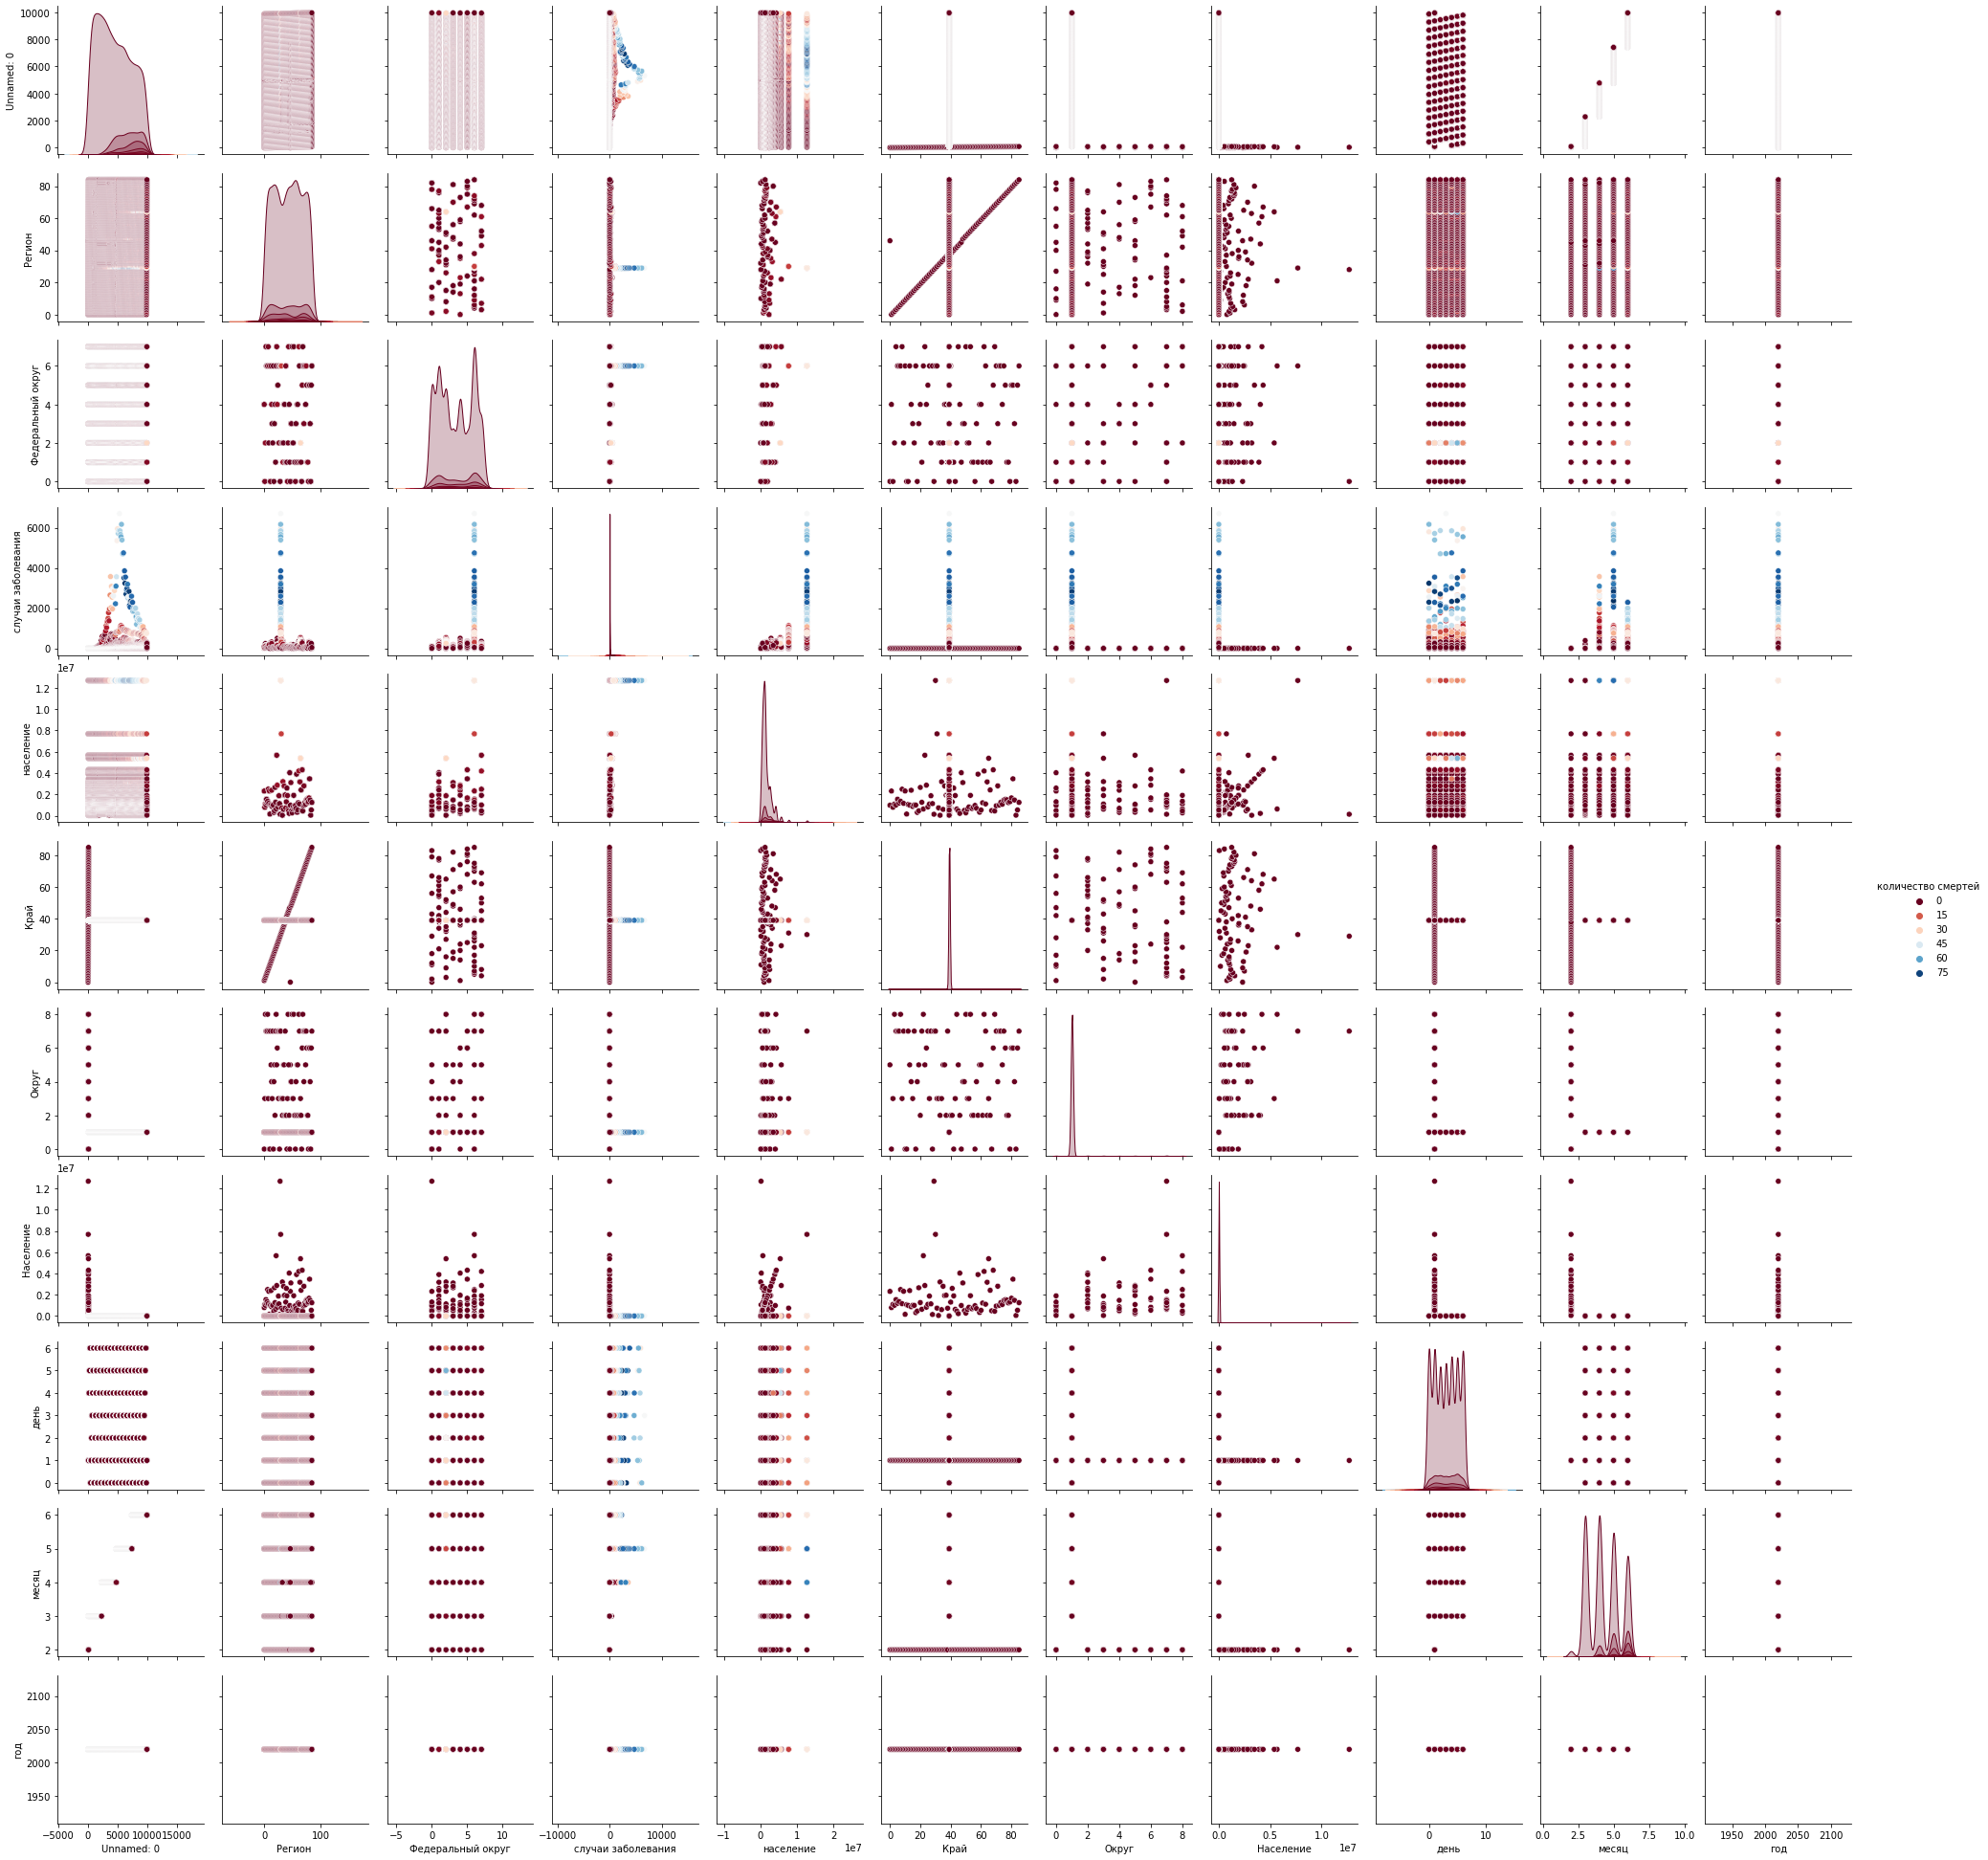

In [18]:
sns.pairplot(data, palette='RdBu', hue='количество смертей');

*Зависимость между признаками хорошая, так как восновном значеня распологаются по всей плоскости,а также заметно, что выбросов в признаках практически нет.*

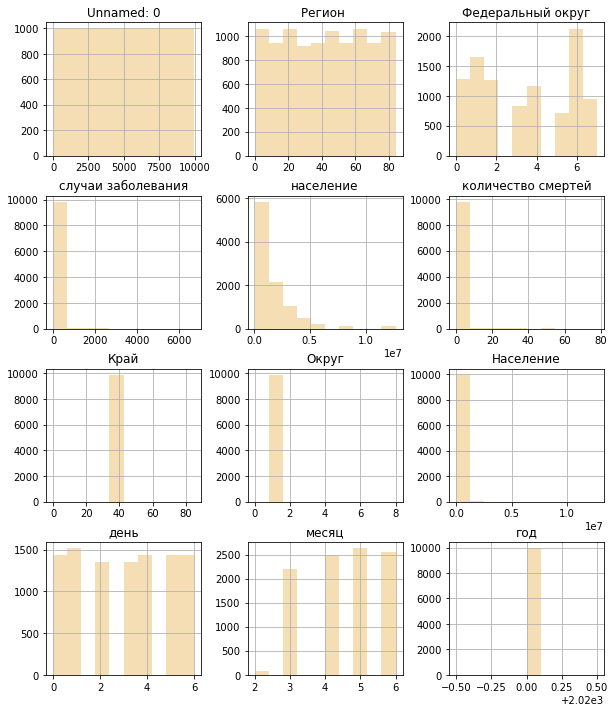

In [19]:
data.hist(color='wheat', figsize=(10,12));

# Кластеризационный анализ

*В этом разделе нужно выбрать алгоритмы кластеризации, обучить предобработанные данные на кластеризации, а также разделить выборку на две части для последующего обуения.*

**Кластеризация**

*Данную выборку я обучу на алгоритмах кластеризации :k-means, так как он прост в реализации и имеет хорошую точность предсказания, и на анализе главных компонентов-который основан на удалении ненужных признаков, тем самым сокращая размер.*

*Обучение на алгоритме k-means:*

In [20]:
X=data.loc[:,['случаи заболевания', 'количество смертей']]
y = data['случаи заболевания']

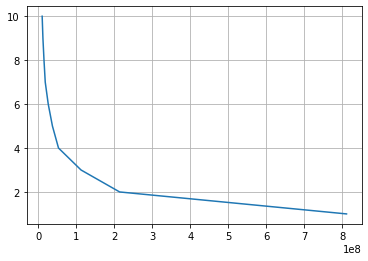

In [21]:
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++').fit(X)
    wcss.append(kmeans.inertia_)
plt.grid()
plt.plot(wcss, range(1,11));

*На графике видно, что точность резко уменьшается на цифре 3, именно поэтому мы разделим данные на 3 кластера.*

In [22]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

In [23]:
X=X.values

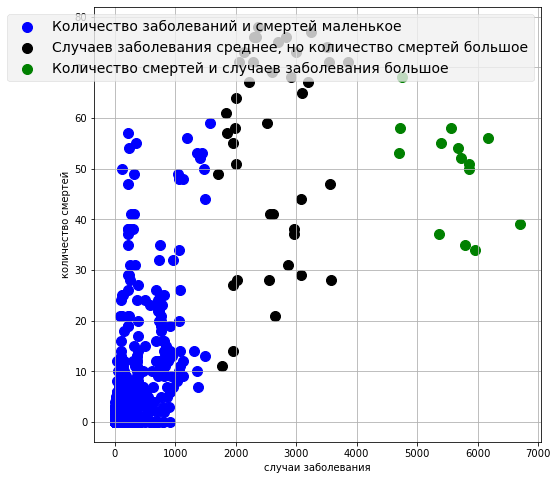

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'blue', label = 'Количество заболеваний и смертей маленькое')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'black', label = 'Случаев заболевания среднее, но количество смертей большое')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Количество смертей и случаев заболевания большое')
plt.style.use('fivethirtyeight')
plt.xlabel('случаи заболевания')
plt.ylabel('количество смертей')
plt.legend()
plt.grid()
plt.show();

*На выведенной диаграмме видно, что больше всего стран присутствет с меньшем количеством заболеваний и с меньшими случаями заболевания, а меньше всего с большим количеством заболеваний и с большими случаями заболевания.*

*Теперь посмотрим на точность алгоритма k-means*

In [25]:
y_pred=kmeans.fit_predict(X)

In [26]:
print("Точность после обработки k_means:{0}".format(homogeneity_score(y_pred, y)))

Точность после обработки k_means:0.997538324101102


*Обучение признака на PCA:*

In [27]:
pca=PCA(n_components=2)

In [28]:
x_pca=pca.fit_transform(X)

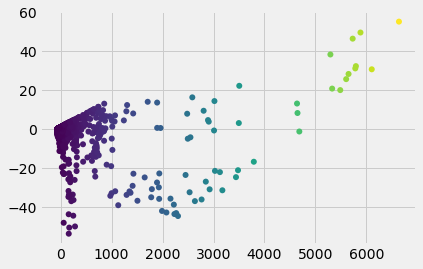

In [29]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, edgecolors='none');

In [30]:
print('Дисперсия составляет [% от оригинала]:{0}'
     .format(sum(pca.explained_variance_ratio_)))

Дисперсия составляет [% от оригинала]:1.0


*Из десперсии можно сделать вывод, что выборка изначальна была без выбросов и все признаки в ней хорошо влияют на целевой признак, так как после обучения признаки не сократились.*

*Под конец разделими наши данные на обучающую и тестувую выборки ля того, что-бы при поступлении новых данных выборка смогла переобучаться корректно.*

In [31]:
scal=MinMaxScaler()
df_scal=scal.fit_transform(data.drop('количество смертей', axis=1))
pd_scal=pd.DataFrame(df_scal, columns=data.drop('количество смертей', axis=1).columns)

In [32]:
x=df_scal.copy()
y=data['количество смертей']

In [33]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.33, random_state=20)

# Обучение признака на классификации

*В этой сессии мы обучим признак на алгоритмах кластеризации, а также построем интерактивную карту о заболеваемости.*

*В качестве алгоритмов классификации я возьму алгоритм Дерево решений, так как он прост в реализации, и имеет мало параметров, XGBoost-это ансамблевый алгоритм, который состоит из протых алгоритмов, это позволяет достич хорошей точности в обучении.*

*Обучение спомощью алгоритма Дерево решений:*

In [34]:
tree=DecisionTreeClassifier(random_state=20)

In [35]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=20)

In [36]:
y_pred=tree.predict(x_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      2629
         1.0       0.21      0.23      0.22       300
         2.0       0.16      0.17      0.16       151
         3.0       0.16      0.16      0.16        74
         4.0       0.00      0.00      0.00        32
         5.0       0.13      0.08      0.10        26
         6.0       0.00      0.00      0.00         9
         7.0       0.00      0.00      0.00         5
         8.0       0.00      0.00      0.00         5
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         2
        13.0       0.00      0.00      0.00         1
        14.0       0.00      0.00      0.00         3
        15.0       0.00      0.00      0.00         2
        16.0       0.00      0.00      0.00         1
        17.0       0.00    

In [38]:
tree.score(x_test, y_test)

0.7259732360097324

*Обучение с помощью алгоритма XGBoost:*

In [39]:
xgb=XGBClassifier(random_state=10)

In [40]:
xgb.fit(x_train, y_train)

[16:24:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [41]:
y_pred=xgb.predict(x_test)

In [42]:
xgb.score(x_test, y_test)

0.7931873479318735

*Лучше всего для обучения оказался алгоритм XGBoost.*

**Интерактивная карта:**

*В начале создания интерактивной карты по данным, загрузим карту со случайными координатами:*

In [43]:
import folium

In [44]:
import folium
map = folium.Map(location=[37.296933,-121.9574983], zoom_start = 8)
map.save("map1.html")

*Добавление маркеров на пустую карту:*

In [45]:
map = folium.Map(location=[37.296933,-121.9574983], zoom_start = 8 , tiles = 'Stamen Terrain')
folium.Marker(location=[37.4074687,-122.086669], popup = "Google HQ", icon=folium.Icon(color = 'gray')).add_to(map);

*Добавление выборки к карте:*

In [46]:
lat = data['количество смертей']
lon = data['случаи заболевания']
elevation = data['Округ']

def color_change(elev):
    if(elev < 1000):
        return('green')
    elif(1000 <= elev <3000):
        return('orange')
    else:
        return('red')

map = folium.Map(location=[37.296933,-121.9574983], zoom_start = 5, tiles = "Stamen Terrain")

for lat, lon, elevation in zip(lat, lon, elevation):
    folium.Marker(location=[lat, lon], popup=str(elevation), icon=folium.Icon(color = color_change(elevation))).add_to(map)

map.save("map1.html")

**Чат-бот**

In [47]:
data=data.astype('int')

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tkinter import *
from nltk import word_tokenize 
from nltk.corpus import stopwords 
import nltk 
import re
from nltk.stem import wordnet 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk import pos_tag 
from sklearn.metrics import pairwise_distances 
from nltk import word_tokenize 
from nltk.corpus import stopwords 
import string
import bs4 as bs
import numpy as np
import urllib.request
import warnings
warnings.filterwarnings("ignore")

In [49]:
raw_html = urllib.request.urlopen('https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_COVID-19_%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8')
raw_html = raw_html.read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')
article_text = ''
for para in article_paragraphs:
    article_text += para.text
article_text = article_text.lower()

In [50]:
article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)
article_text = re.sub(r'\s+', ' ', article_text)

In [51]:
article_sentences = nltk.sent_tokenize(article_text)
article_words = nltk.word_tokenize(article_text)

In [52]:
wnlemmatizer = nltk.stem.WordNetLemmatizer()
def perform_lemmatization(tokens):
    return [wnlemmatizer.lemmatize(token) for token in tokens]

punctuation_removal = dict((ord(punctuation), None) for punctuation in string.punctuation)
def get_processed_text(document):
    return perform_lemmatization(nltk.word_tokenize(document.lower().translate(punctuation_removal)))

In [53]:
def generate_response(user_input):
    tennisrobo_response = ''
    article_sentences.append(user_input)

    word_vectorizer = TfidfVectorizer(tokenizer=get_processed_text, stop_words='english')
    all_word_vectors = word_vectorizer.fit_transform(article_sentences)
    similar_vector_values = cosine_similarity(all_word_vectors[-1], all_word_vectors)
    similar_sentence_number = similar_vector_values.argsort()[0][-2]

    matched_vector = similar_vector_values.flatten()
    matched_vector.sort()
    vector_matched = matched_vector[-2]
    tennisrobo_response = tennisrobo_response + article_sentences[similar_sentence_number]
    return tennisrobo_response

In [54]:
continue_dialogue = True
print("Bot: Введите команду /comand, что-бы посмотреть,\nкакие команды я умею выполнять.")
while(continue_dialogue == True):
    human_text = input()
    human_text = human_text.lower()
    if human_text != '/end':
        if human_text == '/comand':
            print("Bot: Я умею выполнять следующие команды: \n/comand, /predict, /text, /end.")
        elif human_text == '/predict':
            pred=input('Введите номер обекта:')
            print('Bot: Количество смертей в данном объекте:{}'.format(y_pred[int(pred)]))
        elif human_text == '/text':
            intent=input('Введите вопрос:')
            print("Bot:" + generate_response(intent))
            
        else:
            print('Bot: Такие команды я не умею выполнять, введите /comand,что-бы посмотреть,\nкакие команды я умею выполнять.')
    else:
        continue_dialogue = False
        print("Bot: Пока")

Bot: Введите команду /comand, что-бы посмотреть,
какие команды я умею выполнять.
/end
Bot: Пока
